<a href="https://colab.research.google.com/github/surajsrivathsa/ovgu_deeplearning/blob/master/Introspection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Assignment 4:** Introspection

**Team members:**
1. Sanjeeth Busnur Indushekar: 224133 : sanjeeth.busnur@st.ovgu.de
2. Suraj Shashidhar: 230052 : suraj.shashidhar@st.ovgu.de

Tasks To be done

4.1 gradient-based saliency map (sensitivity analysis)

- - Run a batch of inputs through the trained model.

Wrap this in a GradientTape where you watch the input batch.
(batch size can be 1 if you just like to produce a single saliency map)
Compute the gradient for a particular logit or its softmax output with respect to the input.

- This tells us how a change in each input pixel would affect the class output.

- This already gives you a batch of gradient-based saliency maps!

- Plot the saliency map next to the original image or superimpose it.

- Do the saliency maps seem to make sense? How would you interpret them?

Hint: It makes sense to take the sign of the gradient into account when interpreting them.

Negative gradients indicate a decrease in output value, positive gradients an increase.

4.2 Activation Maximization

Extend the code from 4.1 to create an optimal input for a particular class.

- Add the gradients (i.e. the saliency map) to the input. You should multiply the gradients with a small constant (like a learning rate) to make sure the inputs aren’t changed too much.

- Do multiple update steps to make the input more optimal for the chosen output class.
(I recommend implementing your own update step, but you are allowed to use a keras training loop to optimize the input.)

- Does the resulting input look natural?

- How does the inputs change when applying many steps of optimization?

- How do the optimal inputs differ when initializing the optimization with random noise instead of real examples?

Bonus: Apply regularization strategies to make the optimal input more natural-looking.



In [1]:
import os
%tensorflow_version 2.x
import tensorflow as tf
from sklearn import preprocessing
from google.colab import files
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import copy
import numpy as np
from datasets import MNISTDataset

In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import initializers
import tensorboard
import time
from datetime import datetime
from keras import backend as K

Using TensorFlow backend.


In [4]:
print('tensorflow {}'.format(tf.__version__))
print("keras {}".format(keras.__version__))

tensorflow 2.2.0
keras 2.3.0-tf


11493376/11490434 [==============================] - 0s 0us/step
[0 4 1 9 2 1 3 1 4]


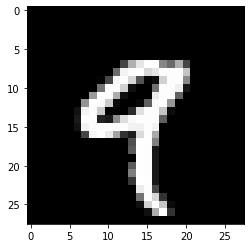

In [5]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
plt.imshow(train_images[4], cmap="Greys_r")
print(train_labels[1:10])

In [6]:
data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)
print(train_images.reshape([-1, 784]).shape)

(60000, 784)


In [7]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
new_train_images = tf.cast(tf.expand_dims(train_images, axis = -1),dtype="float32")
print(new_train_images.shape)

new_test_images = tf.cast(tf.expand_dims(test_images, axis=-1 ),dtype="float32")
print(new_test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
introspection_training_images = tf.cast(tf.expand_dims(train_images, axis = -1),dtype="float32")
introspection_testing_images = tf.cast(tf.expand_dims(test_images, axis=-1 ),dtype="float32")

introspection_training_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
introspection_testing_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

# Pretrain a simple CNN model

In [ ]:
def create_cnn_model():
  model = keras.Sequential()
  model.add(layers.Conv2D(filters=8,kernel_size=(3,3),padding="same",activation="relu" , input_shape=(28, 28, 1), ))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=16,kernel_size=(3,3),padding="same",activation="relu" ))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
  model.add(layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters=64,kernel_size=(1,1),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten(input_shape=(3,3,64)))
  model.add(layers.Dense(units=256, activation="relu"))
  model.add(layers.Dense(units=10,activation="softmax"))
  model.summary()
  return model;

In [ ]:
vgg_cnn_model = create_cnn_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        1

In [ ]:
vgg_cnn_model.compile(optimizer="adam", loss = tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])

In [ ]:
vgg_cnn_model.fit(new_train_images, train_labels,  epochs=3, batch_size=128, validation_data= (new_test_images, test_labels))

Epoch 1/3
469/469 [==============================] - 5s 11ms/step - loss: 0.1188 - accuracy: 0.9636 - val_loss: 0.0642 - val_accuracy: 0.9797
Epoch 2/3
469/469 [==============================] - 5s 10ms/step - loss: 0.0348 - accuracy: 0.9891 - val_loss: 0.0317 - val_accuracy: 0.9904
Epoch 3/3
469/469 [==============================] - 5s 10ms/step - loss: 0.0269 - accuracy: 0.9919 - val_loss: 0.0397 - val_accuracy: 0.9884


In [ ]:
vgg_cnn_model.save("/content/vgg_cnn_model_introspection")

INFO:tensorflow:Assets written to: /content/vgg_cnn_model_introspection/assets


In [ ]:
!zip -r vgg_cnn_model_introspection.zip /content/vgg_cnn_model_introspection

  adding: content/vgg_cnn_model_introspection/ (stored 0%)
  adding: content/vgg_cnn_model_introspection/saved_model.pb (deflated 91%)
  adding: content/vgg_cnn_model_introspection/variables/ (stored 0%)
  adding: content/vgg_cnn_model_introspection/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: content/vgg_cnn_model_introspection/variables/variables.index (deflated 75%)
  adding: content/vgg_cnn_model_introspection/variables/variables.data-00000-of-00002 (deflated 83%)
  adding: content/vgg_cnn_model_introspection/assets/ (stored 0%)


# Saliency Maps

In [12]:
!unzip "/content/vgg_cnn_model_introspection.zip" 

Archive:  /content/vgg_cnn_model_introspection.zip
   creating: content/vgg_cnn_model_introspection/
  inflating: content/vgg_cnn_model_introspection/saved_model.pb  
   creating: content/vgg_cnn_model_introspection/variables/
  inflating: content/vgg_cnn_model_introspection/variables/variables.data-00001-of-00002  
  inflating: content/vgg_cnn_model_introspection/variables/variables.index  
  inflating: content/vgg_cnn_model_introspection/variables/variables.data-00000-of-00002  
   creating: content/vgg_cnn_model_introspection/assets/


In [13]:
vgg_cnn_model = keras.models.load_model(filepath="/content/content/vgg_cnn_model_introspection")


In [14]:
vgg_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        1

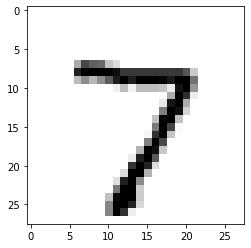

In [15]:
introspection_image = introspection_testing_images[0, :, :, :]
plt.imshow(introspection_image[:, :, 0], cmap="binary")

In [16]:
introspection_prediction = vgg_cnn_model.predict(introspection_testing_images[0:8, :, :, :])
introspection_prediction.shape

(8, 10)

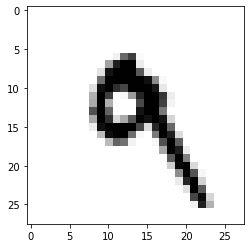

In [18]:
plt.imshow(introspection_testing_images[7,:,:,0], cmap="binary")

In [ ]:
introspection_prediction[7]

array([7.5517782e-08, 2.8742018e-06, 5.9832570e-07, 2.4698878e-07,
       4.1548577e-03, 2.5558513e-06, 4.9061151e-07, 1.7694200e-07,
       8.8357128e-06, 9.9582928e-01], dtype=float32)

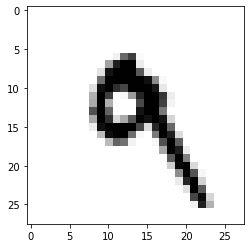

In [ ]:
plt.imshow(new_test_images[7, :, :, 0], cmap="binary")

In [49]:
zero_mask = tf.tile(tf.Variable(initial_value=tf.constant([1,0,0,0,0,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
one_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,1,0,0,0,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
two_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,1,0,0,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
three_mask = tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,1,0,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
four_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,1,0,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
five_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,1,0,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
six_mask = tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,1,0,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
seven_mask = tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,0,1,0,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
eight_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,0,0,1,0], dtype="float32", shape=(1,10))) , multiples=[10000,1])
nine_mask =  tf.tile(tf.Variable(initial_value=tf.constant([0,0,0,0,0,0,0,0,0,1], dtype="float32", shape=(1,10))) , multiples=[10000,1])




In [50]:

with tf.GradientTape() as tape:
  tape.watch(introspection_testing_labels)
  tape.watch(introspection_testing_images)
  introspection_prediction = vgg_cnn_model(introspection_testing_images)
  print(introspection_prediction.shape)
  zero_position_output = tf.multiply(zero_mask,introspection_prediction)
  #ones_position_output = tf.multiply(one_mask,introspection_prediction)
  complete_loss = tf.keras.losses.sparse_categorical_crossentropy(introspection_testing_labels, introspection_prediction)
  zero_grad_loss = tf.keras.losses.sparse_categorical_crossentropy(introspection_testing_labels, zero_position_output)
  #ones_grad_loss = tf.keras.losses.sparse_categorical_crossentropy(test_labels,ones_position_output)

grads = tape.gradient(zero_grad_loss,introspection_testing_images)


(10000, 10)


In [30]:
grads.shape

TensorShape([10000, 28, 28, 1])

In [35]:
grads[0,:,:,:]

<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
array([[[-3.7344172e-10],
        [-2.6963465e-10],
        [-9.0461449e-10],
        [-5.2344129e-10],
        [ 7.7073736e-10],
        [ 9.8358499e-10],
        [-1.2354824e-09],
        [-5.2310201e-10],
        [ 7.2022044e-10],
        [ 1.2051624e-09],
        [ 5.1838867e-10],
        [-1.9751087e-09],
        [-9.1592872e-10],
        [ 6.6577410e-10],
        [ 5.9647309e-10],
        [ 3.1860550e-09],
        [ 1.9253030e-09],
        [-8.2342000e-10],
        [ 1.7935171e-09],
        [ 8.9976748e-10],
        [-1.5017838e-09],
        [-2.0604407e-10],
        [ 5.7793975e-10],
        [ 3.9226786e-10],
        [-1.8037008e-10],
        [-1.1708634e-10],
        [-1.1452404e-10],
        [-1.4401286e-11]],

       [[-5.2461224e-10],
        [ 2.7839123e-10],
        [-8.2907703e-10],
        [-6.4809080e-10],
        [-6.9454842e-10],
        [ 7.9998530e-10],
        [ 2.0400632e-09],
        [ 1.4755142e-09],
        [

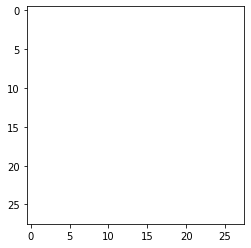

In [59]:
plt.imshow(tf.nn.relu(grads[4,:,:,0]), cmap = "binary")

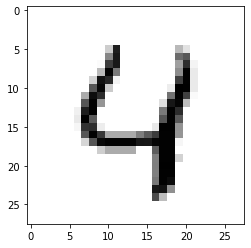

In [60]:
plt.imshow(introspection_testing_images[4,:,:,0], cmap = "binary")

In [25]:
complete_loss

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([2.3841831e-06, 1.3232144e-05, 1.6569955e-05, ..., 1.0728830e-06,
       1.3113013e-06, 2.9380774e-04], dtype=float32)>

In [ ]:
zero_grad_loss

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([2.317216 , 2.632033 , 2.4992614, ..., 2.3025851, 2.3025851,
       3.0723395], dtype=float32)>

In [ ]:
new_test_images = tf.cast(new_test_images,dtype="float32")

In [ ]:
complete_loss[4]

<tf.Tensor: shape=(), dtype=float32, numpy=1.7881378e-06>

In [ ]:
zero_grad_pos.shape

AttributeError: ignored

In [ ]:
print(zero_grad_loss[1])
print(ones_grad_loss[1])

tf.Tensor(2.3025851, shape=(), dtype=float32)
tf.Tensor(2.3025851, shape=(), dtype=float32)


In [ ]:
introspection_prediction.shape

(10000, 10)

In [ ]:
b.shape

TensorShape([10000, 10])

In [ ]:
b[1,:]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
zero_grad_loss = tf.multiply(zero_mask,introspection_prediction)

In [ ]:
zero_grad_loss[4,:]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.3879997e-10, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)>